# Data and Libraries

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
#DATA_PATH = "/kaggle/input/defi-ia-insa-toulouse"
DATA_PATH = '../Data'

In [48]:
train_df = pd.read_json(DATA_PATH+"/train.json").set_index('Id')
test_df = pd.read_json(DATA_PATH+"/test.json")
train_label = pd.read_csv(DATA_PATH+"/train_label.csv").set_index('Id')

In [4]:
train_df.head()

,description,gender
Id,,
0,She is also a Ronald D. Asmus Policy Entrepre...,F
1,He is a member of the AICPA and WICPA. Brent ...,M
2,Dr. Aster has held teaching and research posi...,M
3,He runs a boutique design studio attending cl...,M
4,"He focuses on cloud security, identity and ac...",M


# Train/Test Split

In [5]:
#X = train_df.copy()
#Y = train_label.copy()

In [6]:
#X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [7]:
#d1 = pd.DataFrame(np.transpose([Y_train.Category.value_counts().values/Y_train.shape[0]]), index = Y_train.Category.value_counts().index, columns=['Y_train'])
#d2 = pd.DataFrame(np.transpose([Y_test.Category.value_counts().values/Y_test.shape[0]]), index = Y_test.Category.value_counts().index, columns=['Y_test'])
#d = pd.concat([d1,d2],axis=1,sort=False)
#d

**Pour la submission**

In [49]:
X_train = train_df.copy()
Y_train = train_label.copy()

X_test = test_df.copy()

# Cleaning

In [50]:
X_train["description_lower"] = [x.lower() for x in X_train.description]
X_test["description_lower"] = [x.lower() for x in X_test.description]

# Vectorization

In [51]:
transformer = TfidfVectorizer().fit(X_train["description_lower"].values)
print("NB features: %d" %(len(transformer.vocabulary_)))
X_train = transformer.transform(X_train["description_lower"].values)
X_test = transformer.transform(X_test["description_lower"].values)
X_train

NB features: 230368


<217197x230368 sparse matrix of type '<class 'numpy.float64'>'
	with 9851657 stored elements in Compressed Sparse Row format>

# Rééquilibrage des classes : SMOTE

In [11]:
table1 = Y_train.Category.value_counts(dropna=False)
table1

19    70016
26    18820
20    14646
14    12622
6     12295
11    11607
22    10391
3      9145
8      6616
24     5841
16     5450
5      4621
15     4292
18     4124
1      4115
13     4060
25     3395
9      3121
27     2288
12     1639
0      1497
17     1406
23      967
2       944
7       858
10      831
4       807
21      783
Name: Category, dtype: int64

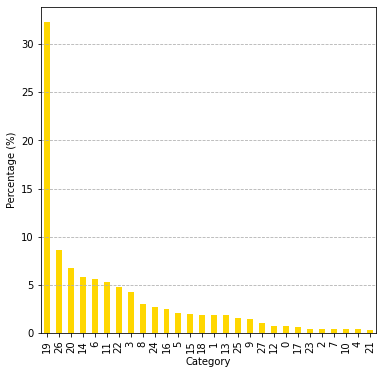

In [12]:
plt.figure(figsize=(6,6))
(Y_train.Category.value_counts(dropna=False,normalize=True)*100).plot(kind="bar",rot=90,color="gold")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.grid(axis="y",linestyle="--")
plt.show()

**Stratégie SMOTE :**
- . < 1 000 : x10
- 1 000 < . < 2 000 : x8
- 2 000 < . < 3 000 : x7
- 3 000 < . < 4 000 : x6
- 4 000 < . < 5 000 : x5
- 5 000 < . < 7 500 : x4
- 7 500 < . < 10 000 : x3
- 10 000 < . < 15 000 : x2
- 15 000 < . < 25 000 : x1.5
- . > 70 000 : à gérer avec undersampling

In [24]:
strategy1 = {0: table1[0]*8,
            1: table1[1]*5,
            2: table1[2]*10,
            3: table1[3]*3,
            4: table1[4]*10,
            5: table1[5]*5,
            6: table1[6]*2,
            7: table1[7]*10,
            8: table1[8]*4,
            9: table1[9]*6,
            10: table1[10]*10,
            11: table1[11]*2,
            12: table1[12]*8,
            13: table1[13]*5,
            14: table1[14]*2,
            15: table1[15]*5,
            16: table1[16]*4,
            17: table1[17]*8,
            18: table1[18]*5,
            19: table1[19],
            20: table1[20]*2,
            21: table1[21]*10,
            22: table1[22]*2,
            23: table1[23]*10,
            24: table1[24]*4,
            25: table1[25]*6,
            26: int(table1[26]*1.5),
            27: table1[27]*7
           }

In [25]:
%%time
os = SMOTE(random_state=0, sampling_strategy=strategy1)
X_train_sample, Y_train_sample = os.fit_sample(X_train, Y_train)

Wall time: 2min 47s


In [26]:
print(X_train.shape[0],"->",X_train_sample.shape[0])

217197 -> 569839


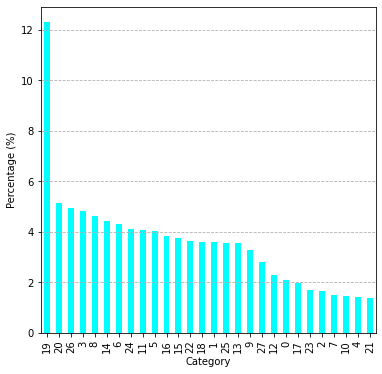

In [27]:
plt.figure(figsize=(6,6))
(Y_train_sample.Category.value_counts(dropna=False,normalize=True)*100).plot(kind="bar",rot=90,color="cyan")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.grid(axis="y",linestyle="--")
plt.show()

In [28]:
table2 = Y_train_sample.Category.value_counts(dropna=False)
table2

19    70016
20    29292
26    28230
3     27435
8     26464
14    25244
6     24590
24    23364
11    23214
5     23105
16    21800
15    21460
22    20782
18    20620
1     20575
25    20370
13    20300
9     18726
27    16016
12    13112
0     11976
17    11248
23     9670
2      9440
7      8580
10     8310
4      8070
21     7830
Name: Category, dtype: int64

**Stratégie Undersampling :**
- . > 70 000 : x0.5

In [29]:
strategy2 = {0: table2[0],
            1: table2[1],
            2: table2[2],
            3: table2[3],
            4: table2[4],
            5: table2[5],
            6: table2[6],
            7: table2[7],
            8: table2[8],
            9: table2[9],
            10: table2[10],
            11: table2[11],
            12: table2[12],
            13: table2[13],
            14: table2[14],
            15: table2[15],
            16: table2[16],
            17: table2[17],
            18: table2[18],
            19: int(table2[19]*0.5),
            20: table2[20],
            21: table2[21],
            22: table2[22],
            23: table2[23],
            24: table2[24],
            25: table2[25],
            26: table2[26],
            27: table2[27]
           }

In [30]:
%%time
X_train_sample, Y_train_sample = RandomUnderSampler(sampling_strategy=strategy2).fit_sample(X_train_sample,Y_train_sample)

Wall time: 957 ms


In [31]:
print(X_train_sample.shape[0])

534831


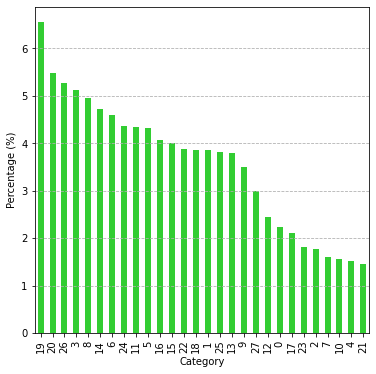

In [32]:
plt.figure(figsize=(6,6))
(Y_train_sample.Category.value_counts(dropna=False,normalize=True)*100).plot(kind="bar",rot=90,color="limegreen")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.grid(axis="y",linestyle="--")
plt.show()

# Learning

We use a simple Logistic Regression model with scikit learn default arguments'value to train the baseline model. 

In [33]:
%%time
model = LogisticRegression(max_iter=500, n_jobs=-1)
model.fit(X_train_sample, Y_train_sample.Category.values)

Wall time: 49min 5s


LogisticRegression(max_iter=500, n_jobs=-1)

In [34]:
#with open("../Model/log_reg_model1.pkl",'wb') as f:
#    pickle.dump(model,f)

# Prediction on test set (after split)

In [32]:
#pred = model.predict(X_test)
#score_f1 = f1_score(Y_test,pred,average='macro')
#print("Score f1:",score_f1)

Score f1: 0.7420696957707199


**Rééquilibrage :**
- sans : 0.73
- smote+undersampling : 0.74

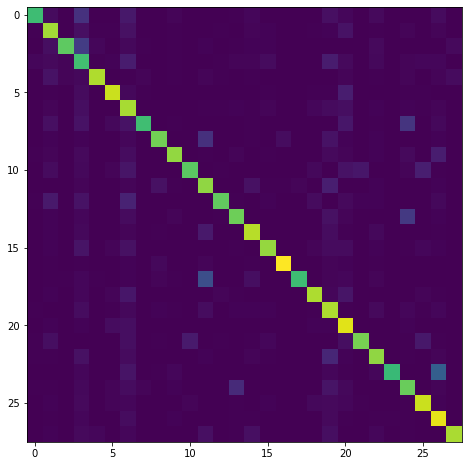

In [35]:
#plt.figure(figsize=(8,8))
#plt.imshow(confusion_matrix(Y_test, pred,normalize='true'))
#plt.show()

# Prediction & File Generation (on the real test set)

In [52]:
predictions = model.predict(X_test)

In [53]:
predictions.shape

(54300,)

In [54]:
X_test = pd.DataFrame.sparse.from_spmatrix(X_test)

In [56]:
X_test["Category"] = predictions

In [58]:
submission_file = X_test["Category"]
submission_file.head(2)

0     6
1    20
Name: Category, dtype: int64

In [60]:
submission_file.to_csv(DATA_PATH+"/submission1.csv", index_label="Id")